In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, exists, isdir
from glob import glob

import torch
import cv2
import numpy as np
from PIL import Image

from relfm.utils.visualize import show_grid_of_images, show_keypoint_matches, show_single_image
from relfm.utils.matching import mnn_matcher, add_kps_to_image, find_matches
from lib.r2d2.extract import extract_keypoints_modified


In [3]:
DATA_ROOT = "/home/lcur1325/datasets/hpatches-sequences-release/"

### Select a sample folder to test

In [4]:
category = "v_churchill"
category_folder = join(DATA_ROOT, category)

image_paths = sorted(glob(join(category_folder, "*.ppm")))
homography_paths = sorted(glob(join(category_folder, "H_*_*")))

In [5]:
img1_path = image_paths[0]
img2_path = image_paths[3]

H_path = homography_paths[3 - 1]

In [6]:
img1_path, img2_path, H_path

('/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/1.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/4.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_churchill/H_1_4')

### Load a pair of images and homography

In [7]:
img1, img2 = Image.open(img1_path), Image.open(img2_path)
img1_np, img2_np = np.asarray(img1), np.asarray(img2)

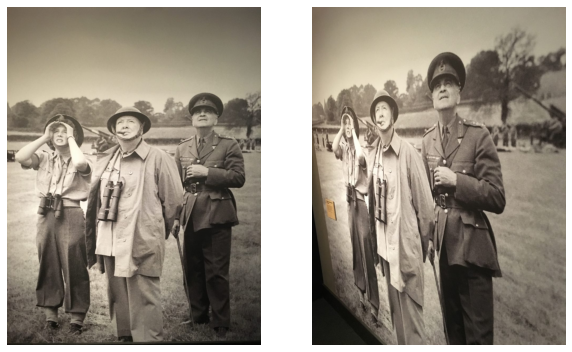

In [8]:
show_grid_of_images([img1_np, img2_np], n_cols=2, figsize=(10, 8))

In [9]:
H = np.loadtxt(H_path)

In [10]:
H

array([[ 3.1237e-01,  9.9342e-02,  8.5389e+00],
       [-2.9392e-01,  9.2363e-01,  1.4629e+01],
       [-7.4642e-04,  6.3257e-05,  9.9168e-01]])

### Apply rotation on second image

In [11]:
H1, W1 = img1_np.shape[:2]
C0 = np.array([W1/2. , H1/2.])

In [44]:
rotation = 30
if rotation == 0:
    # no change
    H = np.loadtxt(H_path)
    img2 = Image.open(img2_path)
else:
    
    H = np.loadtxt(H_path)
    img2 = Image.open(img2_path)
    img2 = img2.rotate(rotation).copy()
    
    rotation_in_rad = np.radians(rotation)
    rotation_in_rad = -rotation_in_rad
    R = np.array([
        [np.cos(rotation_in_rad), -np.sin(rotation_in_rad),],
        [np.sin(rotation_in_rad), np.cos(rotation_in_rad)],
    ])
    t_due_to_R = C0 - R @ C0
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t_due_to_R
    
    # H = np.dot(T, H)
    H = T @ H
    
img1_np, img2_np = np.asarray(img1), np.asarray(img2)

In [45]:
T

array([[   0.8660254 ,    0.5       , -204.55375505],
       [  -0.5       ,    0.8660254 ,  260.59499326],
       [   0.        ,    0.        ,    1.        ]])

In [46]:
H

array([[ 2.76243369e-01,  5.34908239e-01, -1.88142463e+02],
       [-6.05240502e-01,  7.66700501e-01,  2.66826479e+02],
       [-7.46420000e-04,  6.32570000e-05,  9.91680000e-01]])

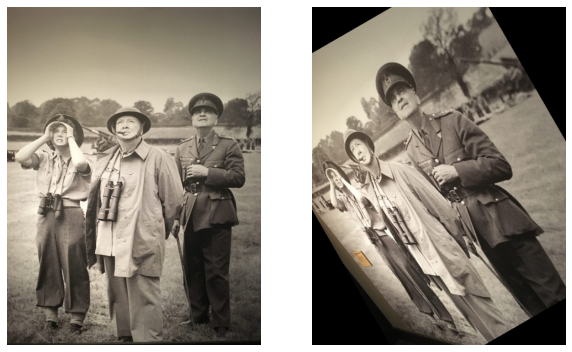

In [47]:
show_grid_of_images([img1_np, img2_np], n_cols=2, figsize=(10, 8))

### Check rotation correctness

In [48]:
# show_single_image(add_kps_to_image(img1_np, np.array([[400, 400]])))

In [49]:
def apply_homography_to_keypoints(kps1, homography):
    """Applies H to keypoints in image 1."""
    
    N = kps1.shape[0]
    if kps1.shape[1] == 3:
        pos_a = kps1[:, :2]
    elif kps1.shape[1] == 2:
        pos_a = kps1
    else:
        raise ValueError("Invalid shape for kps1.")
    
    # homogenize
    pos_a_h = np.concatenate([pos_a, np.ones([N, 1])], axis=1)
    
    # apply homography
    pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
    
    # back to 2D coordinates
    pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]
    
    return pos_b_proj

In [50]:
def kp2tuple(kp: np.ndarray):
    kp = kp.astype(int)
    return (kp[1], kp[0])

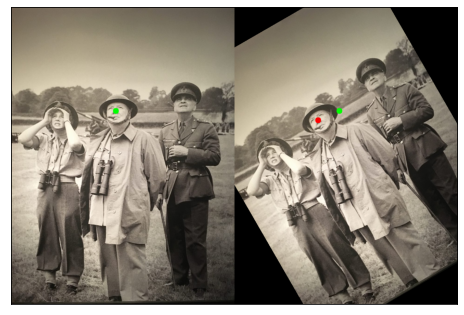

In [51]:
rotation = 30
combined_image = np.concatenate([img1_np, np.asarray(img1.rotate(rotation))], axis=1)

H1, W1 = img1_np.shape[:2]
kp = np.array([360, 360], dtype=int)
cv2.circle(combined_image, tuple(kp), 10, (0, 255, 0), -1)

# kp2 = kp2tuple(kp_transformed[0])

# kp_transformed = apply_homography_to_keypoints(kp.reshape((1, 2)), R)

# kp_transformed = R @ np.concatenate([kp, np.ones(1)], axis=0)
# kp_transformed = kp_transformed[:2]
# kp_transformed = apply_homography_to_keypoints(kp_transformed, R.T)

rotation_in_rad = -np.radians(rotation)
R = np.array([
    [np.cos(rotation_in_rad), -np.sin(rotation_in_rad), 0.],
    [np.sin(rotation_in_rad), np.cos(rotation_in_rad), 0.],
    [0., 0., 1.],
])

# kp_transformed = kp.copy()
kp_in_image_center_coordinates = kp - (W1 / 2, H1/2)
kp_transformed = (R @ np.concatenate([kp_in_image_center_coordinates, np.ones(1)], axis=0))[:2]
kp_transformed += (W1/2, H1/2)
kp_transformed = kp_transformed.astype(int)
kp_transformed[0] += W1
kp_copy = kp.copy()
kp_copy[0] += W1
cv2.circle(combined_image, kp_copy, 10, (0, 255, 0), -1)
cv2.circle(combined_image, kp_transformed, 10, (255, 0, 0), -1)

show_single_image(combined_image)

In [52]:
kp_transformed

array([1055,  392])

In [53]:
kp_in_image_center_coordinates

array([ -24., -152.])

In [54]:
R @ np.concatenate([kp, np.ones(1)], axis=0)

array([491.76914536, 131.76914536,   1.        ])

### Extract keypoints and descriptors for both images

In [55]:
model_path = "../checkpoints/r2d2_WASF_N16.pt"
outputs = extract_keypoints_modified([img1, img2], model_path)

Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )
extracting at scale x1.00 =  768x1024
extracting at scale x0.84 =  646x861
extracting at scale x0.71 =  543x724
extracting at scale x0.59 =  457x609
extracting at scale x0.50 =  384x512
extracting at scale x0.42 =  323x431
extracting at scale x0.35 =  272x362
extracting at scale x0.30 =  228x304
extracting at scale x0.25 =  192x256
extracting at scale x1.00 =  768x1024
extracting at scale x0.84 =  646x861
extracting at scale x0.71 =  543x724
extracting at scale x0.59 =  457x609
extracting at scale x0.50 =  384x512
extracting at scale x0.42 =  323x431
extracting at scale x0.35 =  272x362
extracting at scale x0.30 =  228x304
extracting at scale x0.25 =  192x256


### Apply homohraphy to keypoints detected in image 1

In [28]:
kps1 = outputs[0]["keypoints"]
des1 = outputs[0]["descriptors"]

kps2 = outputs[1]["keypoints"]
des2 = outputs[1]["descriptors"]

In [29]:
dist, matches = mnn_matcher(torch.from_numpy(des1), torch.from_numpy(des2))

In [30]:
matches.shape

(113, 2)

In [31]:
kps1.shape

(5000, 3)

In [32]:
kps2_gt = apply_homography_to_keypoints(kps1[:, :2], H)

In [33]:
kps1.shape, kps2.shape, kps2_gt.shape, matches.shape

((5000, 3), (5000, 3), (5000, 2), (113, 2))

#### Visualize detected and ground truth keypoints

In [34]:
img1_with_detected_kps1, kps1_cv2 = add_kps_to_image(img1_np, kps1)
img2_with_detected_kps2, kps2_cv2 = add_kps_to_image(img2_np, kps2)

img2_with_detected_kps2_and_gt_kps2, kps2_gt_cv2 = add_kps_to_image(img2_with_detected_kps2, kps2_gt, color=(0, 255, 0))

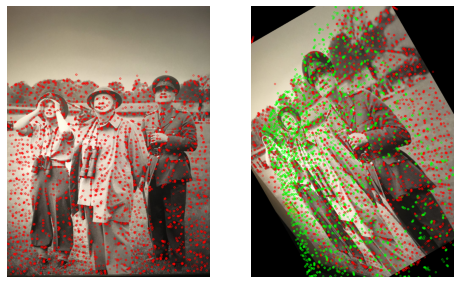

In [35]:
show_grid_of_images([img1_with_detected_kps1, img2_with_detected_kps2_and_gt_kps2], n_cols=2)

In [36]:
kps1.shape

(5000, 3)

### Find matches and visualize GT matches and predicted matches

In [37]:
matches.shape, kps1.shape, kps2.shape, kps2_gt.shape

((113, 2), (5000, 3), (5000, 3), (5000, 2))

In [38]:
img1_np.shape, img2_np.shape

((1024, 768, 3), (1024, 768, 3))

In [39]:
H1, W1 = img1_np.shape[:2]

In [40]:
combined_image = np.concatenate([img1_np, img2_np], axis=1)

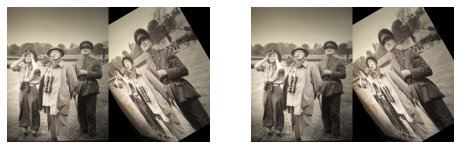

In [41]:
show_grid_of_images([combined_image, combined_image], n_cols=2)

In [42]:

# set error threshold (in pixels)
# ideally, we should set a range of values
# but for now, using a single value
thr = 5

comb_img_with_matches = combined_image.copy()

for idx1, idx2 in matches:

    kp1 = kps1[idx1, :2].copy()
    kp2 = kps2[idx2, :2].copy()
    kp2[1] += W1
    
    kp2_gt = kps2_gt[idx1, :2].copy()
    kp2_gt[1] += W1
    
    dist = np.sqrt(np.sum((kp2 - kp2_gt) ** 2))
    
    if dist < thr:
        # color the match green
        color = (0, 255, 0)
    else:
        # color the match red
        color = (255, 0, 0)
    
    kp1 = kp1.astype(int)
    kp1 = (kp1[1], kp1[0])
    kp2 = kp2.astype(int)
    kp2 = (kp2[1], kp2[0])
    cv2.line(comb_img_with_matches, kp1, kp2, color, 1)
    cv2.circle(comb_img_with_matches, kp1, 4, color, -1)
    cv2.circle(comb_img_with_matches, kp2, 4, color, -1)

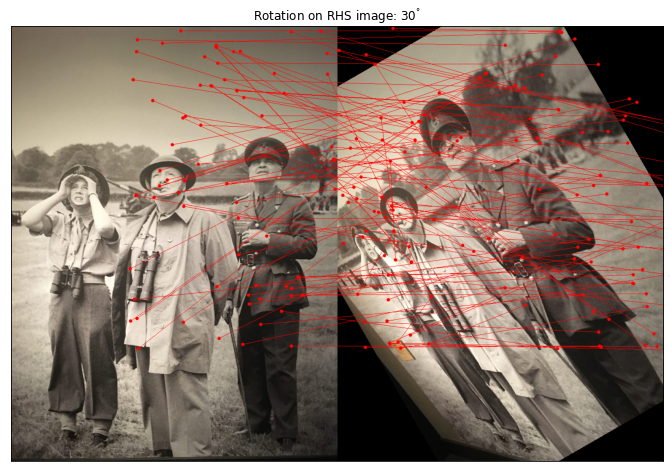

In [43]:
show_single_image(comb_img_with_matches, figsize=(15, 8), title=f"Rotation on RHS image: {rotation}$^\degree$")

### Extras

In [ ]:
matches_cv2 = find_matches(des1, des2)

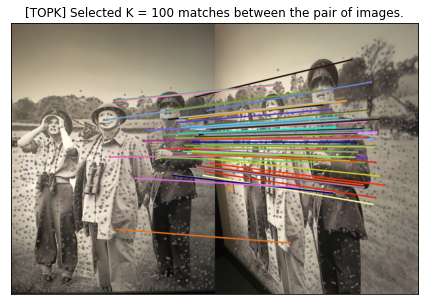

In [80]:
matches_img = show_keypoint_matches(
    img1_np, kps1_cv2, img2_np, kps2_cv2, matches_cv2, choose_matches="topk", K=100, 
)

In [81]:
kps1.shape, kps2.shape, kps2_gt.shape

((5000, 3), (5000, 3), (5000, 2))

In [86]:
kps1_selected = kps1[matches[:, 0]]
kps2_gt_selected = kps2_gt[matches[:, 0]]

In [87]:
kps1_selected.shape, kps2_gt_selected.shape

((913, 3), (913, 2))

In [ ]:
matches_by_homography = np.array()